# Consurso interno de predicción de Oracle
Alejandro Ozymandias Cepeda Beltran

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Obtención de datos del stock de Oracle

In [34]:
datos_orcl = pd.read_csv('oracle_stock_prices.csv')
print(datos_orcl.shape)
datos_orcl.head()

(726, 6)


,Date,Open,High,Low,Close,Volume
0,3/01/2023 16:00:00,"82,47","83,84","82,26","83,72",8997534
1,4/01/2023 16:00:00,"84,2","85,17","83,64","84,48",7836238
2,5/01/2023 16:00:00,85,"85,4","83,22","84,31",7643784
3,6/01/2023 16:00:00,"84,74","86,34","83,82","85,66",8641597
4,9/01/2023 16:00:00,"86,84","87,59","86,16","86,42",7519836


In [41]:

close_data = datos_orcl['Close'].values
for i in range(len(close_data)):
    a = close_data[i].replace(',','.')
    close_data[i] = float(a)
print(close_data)

[83.72 84.48 84.31 85.66 86.42 86.5 88.6 88.78 89.2 88.6 86.71 85.94 87.25
 88.97 89.7 89.64 89.83 88.99 87.35 88.46 90.05 89.38 89.62 88.53 87.74
 86.69 86.65 87.14 89.42 89.09 88.34 87.72 87.28 86.2 86.32 88.58 88.66
 87.96 87.4 86.34 86.97 89.25 89.74 88.36 88.49 86.87 84.07 84.93 84.56
 82.98 84.82 85.26 86.96 87.58 87.9 87.78 88.01 90.14 89.85 90.62 90.51
 92.92 93.92 94.0 94.89 95.92 93.76 93.97 93.9 95.55 95.71 95.59 96.47
 95.81 94.83 95.15 95.44 94.06 93.71 95.04 94.72 94.87 94.8 94.78 94.97
 96.97 96.79 96.14 97.52 97.44 97.85 97.26 98.25 99.77 102.34 102.84
 101.77 98.54 98.32 104.29 104.08 105.15 105.94 105.99 105.89 106.93 107.1
 105.25 107.48 109.85 116.43 116.68 122.27 126.55 125.46 122.04 122.1
 120.58 118.64 116.78 117.84 116.53 117.78 119.09 117.15 115.96 115.45
 114.61 114.38 114.88 116.02 117.45 119.27 118.89 120.77 118.69 115.88
 117.65 118.07 117.95 115.5 116.4 115.99 117.23 117.91 115.71 114.55
 114.44 116.1 115.23 113.1 112.99 113.06 115.57 117.29 115.34 114.88


### 1. CONFIGURACIÓN Y GENERACIÓN DE DATOS

In [5]:
def crear_secuencias(datos, ventana):
    """
    Transforma una serie plana en pares (entrada, objetivo).
    Entrada: [0, 1, 2, 3, 4, 5] y ventana=3
    Salida X: [[0,1,2], [1,2,3], [2,3,4]]
    Salida y: [3, 4, 5]
    """
    secuencias = []
    labels = []
    L = len(datos)
    for i in range(L - ventana):
        # Tomamos 'ventana' pasos como input
        seq = datos[i : i + ventana]
        # El siguiente paso es lo que queremos predecir
        label = datos[i + ventana]
        secuencias.append(seq)
        labels.append(label)
    return np.array(secuencias), np.array(labels)

# Crear datos de onda senoidal
t = np.linspace(0, 100, 1000)
datos = np.sin(t)

print(datos.shape)

# Hiperparámetros
ventana_tiempo = 50  # Cuántos pasos hacia atrás mira la red
test_size = 200

# Preparar dataset
X, y = crear_secuencias(datos, ventana_tiempo)

X


(1000,)


array([[ 0.        ,  0.09993302,  0.19886554, ..., -0.99997048,
        -0.9957327 , -0.98152597],
       [ 0.09993302,  0.19886554,  0.29580708, ..., -0.9957327 ,
        -0.98152597, -0.95749254],
       [ 0.19886554,  0.29580708,  0.3897871 , ..., -0.98152597,
        -0.95749254, -0.92387301],
       ...,
       [ 0.52014028,  0.60288742,  0.67959865, ..., -0.85805249,
        -0.80243543, -0.73878464],
       [ 0.60288742,  0.67959865,  0.74950597, ..., -0.80243543,
        -0.73878464, -0.6677374 ],
       [ 0.67959865,  0.74950597,  0.81190948, ..., -0.73878464,
        -0.6677374 , -0.59000499]])

### 2. PREPARACIÓN DE TENSORES

In [6]:
# Dividir en train/test
train_X = torch.Tensor(X[:-test_size])
train_y = torch.Tensor(y[:-test_size])
test_X = torch.Tensor(X[-test_size:])
test_y = torch.Tensor(y[-test_size:])

# Añadir la dimensión de "Features" (Input_Size) al final
# De (Batch, 50) pasamos a (Batch, 50, 1)
train_X = train_X.unsqueeze(-1)
test_X = test_X.unsqueeze(-1)
# Las etiquetas también necesitan forma correcta para el Loss
train_y = train_y.unsqueeze(-1)
test_y = test_y.unsqueeze(-1)

print(f"Forma de entrada a la LSTM: {train_X.shape}") # (Batch, 50, 1)

Forma de entrada a la LSTM: torch.Size([750, 50, 1])


### 3. Definición del modelo

In [7]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_layers=1):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        # Definición de la capa LSTM
        self.lstm = nn.LSTM(
            input_size=input_dim,     # 1 (solo el valor del seno)
            hidden_size=hidden_dim,   # 50 neuronas en la memoria
            num_layers=num_layers,    # 1 capa apilada
            batch_first=True          # Importante para usar (Batch, Seq, Feat)
        )
        
        # Capa lineal para decodificar la salida de la LSTM a un solo valor
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x shape: (Batch, Seq_Len, Features)
        
        # LSTM devuelve: output, (hidden_state, cell_state)
        # output contiene los estados ocultos de TODA la secuencia
        lstm_out, _ = self.lstm(x)
        
        # Solo nos interesa la predicción del ÚLTIMO paso de tiempo
        # Tomamos el último slice temporal: [:, -1, :]
        last_time_step = lstm_out[:, -1, :]
        
        # Pasamos por la lineal para obtener la predicción final
        prediccion = self.linear(last_time_step)
        
        return prediccion
    
# Instanciar modelo, pérdida y optimizador
modelo = LSTMPredictor()
loss_function = nn.MSELoss() # Error Cuadrático Medio (estándar para regresión)
# Optimizador Adam con learning rate de 0.001
optimizer = optim.Adam(modelo.parameters(), lr=0.001)


### 4. Entrenamiento

In [8]:
epochs = 25
grafica = []
print("\nIniciando entrenamiento...")

for i in range(epochs):
    modelo.train()
    
    # 1. Resetear gradientes
    optimizer.zero_grad() 
    
    # 2. Forward pass (Predecir)
    y_pred = modelo(train_X)
    
    # 3. Calcular pérdida
    loss = loss_function(y_pred, train_y)
    
    # 4. Backward pass (Calcular gradientes)
    loss.backward()
    
    # 5. Actualizar pesos
    optimizer.step() 
    
    #if i%5  == 0:
    grafica.append(loss.item())
    print(f'Epoch {i} Loss: {loss.item():.6f}')

print("Entrenamiento finalizado.\n")


Iniciando entrenamiento...
Epoch 0 Loss: 0.491178
Epoch 1 Loss: 0.482819
Epoch 2 Loss: 0.474503
Epoch 3 Loss: 0.466205
Epoch 4 Loss: 0.457910
Epoch 5 Loss: 0.449602
Epoch 6 Loss: 0.441262
Epoch 7 Loss: 0.432864
Epoch 8 Loss: 0.424381
Epoch 9 Loss: 0.415778
Epoch 10 Loss: 0.407023
Epoch 11 Loss: 0.398077
Epoch 12 Loss: 0.388903
Epoch 13 Loss: 0.379459
Epoch 14 Loss: 0.369703
Epoch 15 Loss: 0.359590
Epoch 16 Loss: 0.349076
Epoch 17 Loss: 0.338119
Epoch 18 Loss: 0.326682
Epoch 19 Loss: 0.314737
Epoch 20 Loss: 0.302276
Epoch 21 Loss: 0.289319
Epoch 22 Loss: 0.275936
Epoch 23 Loss: 0.262267
Epoch 24 Loss: 0.248560
Entrenamiento finalizado.



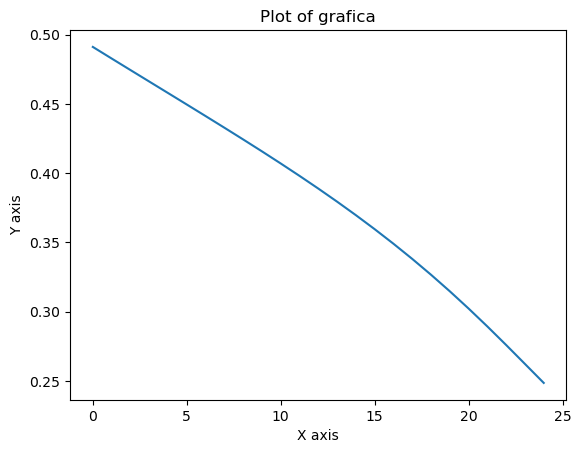

In [9]:
################# Gráfica de codo ####################

# Import required libraries
import matplotlib.pyplot as plt

# Create a simple line plot
plt.plot(grafica)

# Add labels and title
plt.xlabel('X axis')
plt.ylabel('Y axis') 
plt.title('Plot of grafica')

# Display the plot
plt.show()

### 5. Evaluación

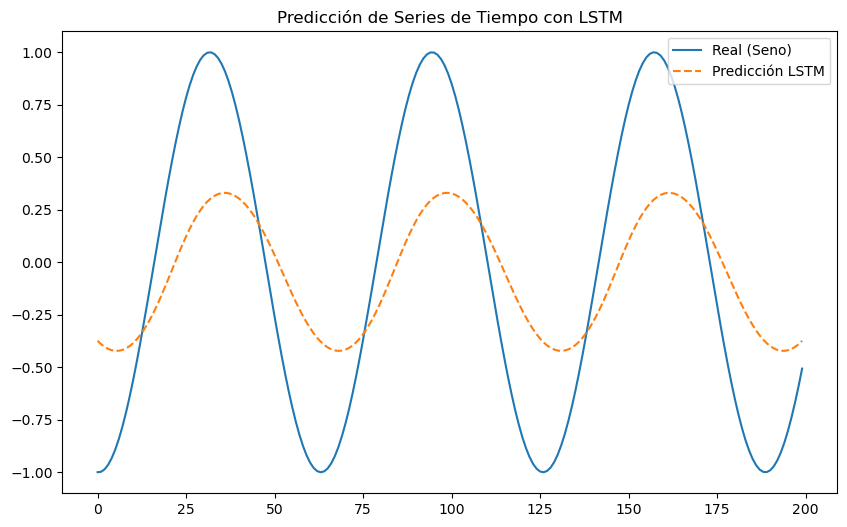

Ejemplo de predicción vs real:
Real: -0.9995 | Predicho: -0.3739


In [10]:
modelo.eval()
with torch.no_grad():
    test_pred = modelo(test_X)

# Convertir a numpy para graficar
real = test_y.numpy()
predicho = test_pred.numpy()

# Descomenta las siguientes líneas si estás en un entorno con pantalla gráfica (Jupyter/Local)
plt.figure(figsize=(10,6))
plt.plot(real, label='Real (Seno)')
plt.plot(predicho, label='Predicción LSTM', linestyle='dashed')
plt.legend()
plt.title('Predicción de Series de Tiempo con LSTM')
plt.show()

print("Ejemplo de predicción vs real:")
print(f"Real: {real[0][0]:.4f} | Predicho: {predicho[0][0]:.4f}")